# Оптимизация маркетинговыхзатрат Яндекс.Афиши

Цель проекта: оптимизация маркетинговых затрат Яндекс.Афиши

Задачи проекта:
- изучение показателей базы данных; выявление закономерностей;
- определение прибыльных и убыточных рекламных источников.

## План проекта

1. Загрузка и анализ данных
2. Предобработка данных
3. Расчет метрик
3.1. Продукт
3.2. Продажи
3.3. Маркетинг
4. Выводы

### 1. Загрузка и анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')
visits.info()
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [2]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [3]:
costs.info()
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Выводы

Данные загружены. Выведена информация о данных. Выведены первые 5 значений переменных. В данных нет пропусков, об этом свидетельствует количество значений в переменных. Несколько переменных нуждаются в изменении типа:
End Ts, Start Ts, Buy Ts, dt - из object в datetime.
Также нужно скорректировать названия столбцов в таблицах visits и orders, чтобы они состояли из прописных букв и не имели пробелов.

### 2. Предобработка данных

In [4]:
visits = visits.rename({'Device': 'device', 'End Ts': 'end_ts', 'Source Id': 'source_id', 'Start Ts': 'start_ts', 
                         'Uid': 'uid'}, axis = 1)
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M')
visits['uid'] = visits['uid'].astype(object)
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null object
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 13.7+ MB


In [5]:
orders = orders.rename({'Buy Ts': 'buy_ts', 'Revenue': 'revenue', 'Uid': 'uid'}, axis = 1)
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d %H:%M')
orders['uid'] = orders['uid'].astype(object)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null object
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.2+ MB


In [6]:
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Корректируем названия столбцов в таблицах: названия из строчных букв и без пробелов.
Меняем тип данных переменных End Ts, Start Ts, Buy Ts, dt из object в datetime. 
Проверяем.

In [7]:
print(visits.duplicated().sum())# проверка на дубли

0


In [8]:
print(orders.duplicated().sum())# проверка на дубли

0


In [9]:
print(costs.duplicated().sum())# проверка на дубли

0


Проверяем таблицы на дубли. Дублей нет.

### 3. Расчет метрик

#### 3.1. Продукт

#### Сколько людей пользуются в день, неделю, месяц?

Среднее количество заходов в день:
uid    907.991758
dtype: float64


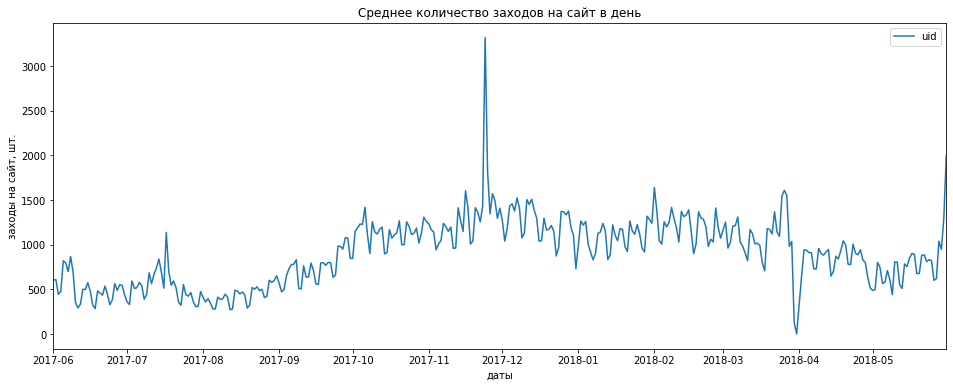

In [10]:
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date
dau = visits.groupby('session_date').agg({'uid': 'nunique'})
print('Среднее количество заходов в день:')
print(visits.groupby('session_date').agg({'uid': 'nunique'}).mean())
dau.plot.line(figsize = (16, 6), title = 'Среднее количество заходов на сайт в день');
plt.xlabel("даты")
plt.ylabel("заходы на сайт, шт.");

Рассчитаем сколько людей в среднем пользуются Яндекс.Афишей в день. Построим график.
В среднем на Яндекс афишу заходят в день - 908 пользователей.
На графике прослеживается сезонность, но есть и выбросы.

Среднее количество заходов в неделю
uid    5716.245283
dtype: float64


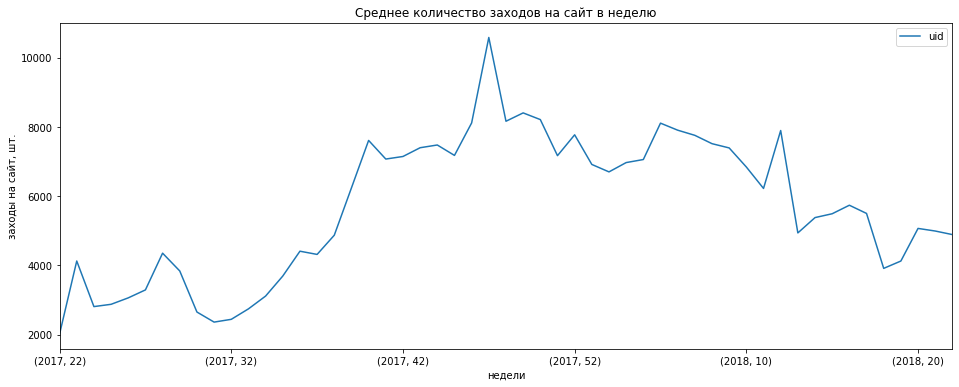

In [11]:
wau = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'})
print('Среднее количество заходов в неделю')
print(visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean())
wau.plot.line(figsize = (16, 6), title = 'Среднее количество заходов на сайт в неделю');
plt.xlabel("недели")
plt.ylabel("заходы на сайт, шт.");

Рассчитаем сколько людей в среднем пользуются Яндекс.Афишей в неделю. Построим график.
В среднем на Яндекс афишу заходят в неделю - 5716 пользователей.

Среднее количество заходов в неделю
uid    23228.416667
dtype: float64


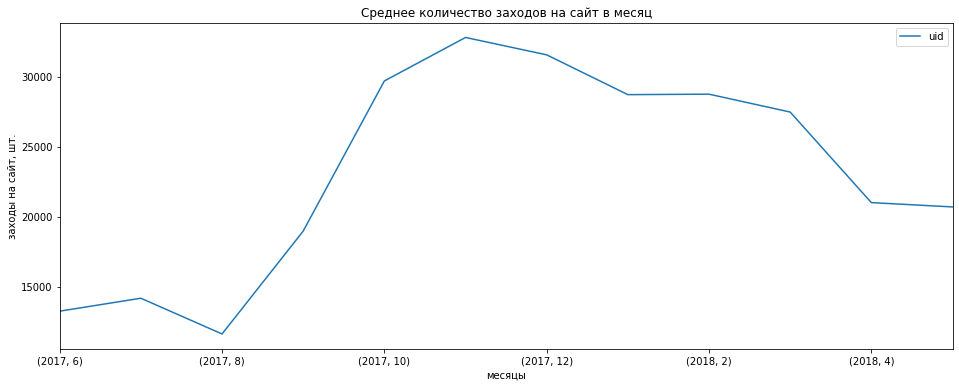

In [12]:
mau = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'})
print('Среднее количество заходов в неделю')
print(visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean())
mau.plot.line(figsize = (16, 6), title = 'Среднее количество заходов на сайт в месяц');
plt.xlabel("месяцы")
plt.ylabel("заходы на сайт, шт.");

Рассчитаем сколько людей в среднем пользуются Яндекс.Афишей в месяц. Построим график.
В среднем на Яндекс афишу заходят в месяц - 23228 пользователей.
Четко прослеживается сезонность: максимальная посещаемость наблюдается с ноября по февраль, минимальная - с июня по август.

#### Сколько сессий в день?

count    364.000000
mean       1.082170
std        0.020876
min        1.000000
25%        1.070321
50%        1.082488
75%        1.093876
max        1.217837
dtype: float64


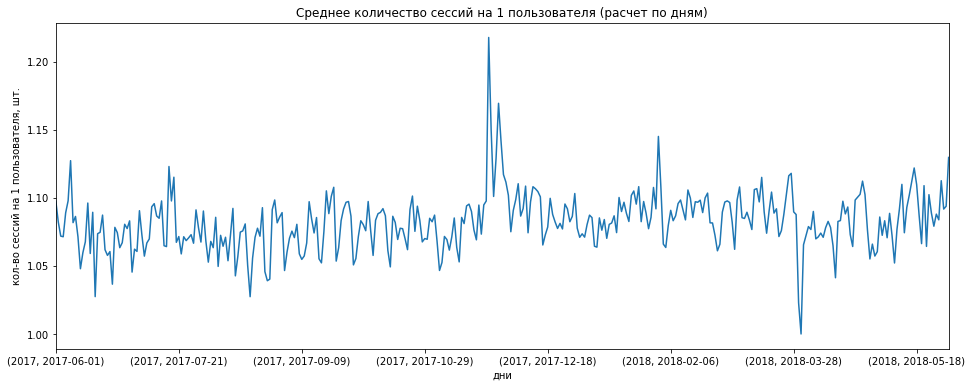

In [13]:
sessions_per_day = visits.groupby(['session_year', 'session_date']).agg({'uid': ['count','nunique']})
sessions_per_day.columns = ['n_sessions', 'n_users']
sessions_per_user = sessions_per_day['n_sessions']/sessions_per_day['n_users']
print(sessions_per_user.describe())
sessions_per_user.plot.line(figsize = (16, 6), title = 'Среднее количество сессий на 1 пользователя (расчет по дням)');
plt.xlabel("дни")
plt.ylabel("кол-во сессий на 1 пользователя, шт.");

Рассчитаем среднее количество сессий на 1 пользователя в день. Построим график. 
Среднее приблизительно равно медиане и составило 1,08 сессий в день. График получился не показательным.

count    12.000000
mean      1.280889
std       0.032217
min       1.234202
25%       1.259190
50%       1.281448
75%       1.294672
max       1.340641
dtype: float64


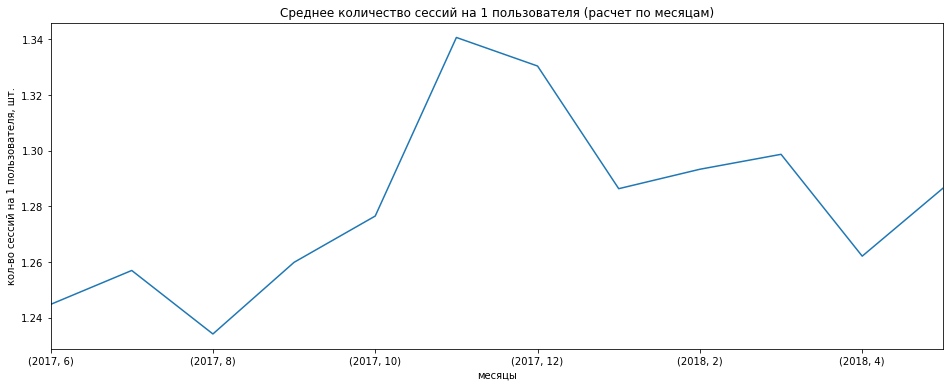

In [14]:
sessions_per_month = visits.groupby(['session_year', 'session_month']).agg({'uid': ['count','nunique']})
sessions_per_month.columns = ['n_sessions', 'n_users']
sessions_per_user_m = sessions_per_month['n_sessions']/sessions_per_month['n_users']
print(sessions_per_user_m.describe())
sessions_per_user_m.plot.line(figsize = (16, 6), title = 'Среднее количество сессий на 1 пользователя (расчет по месяцам)');
plt.xlabel("месяцы")
plt.ylabel("кол-во сессий на 1 пользователя, шт.");

Рассчитаем среднее количество сессий на 1 пользователя в день помесячно. Построим график. 
Среднее приблизительно равно медиане и составило 1,28 сессий в день. 
Максимальные значения наблюдаются в ноябре-декабре, минимальные - в августе.

#### Сколько длится одна сессия?

[array([120.,   0.]), array([ 840., 1920.])]
count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64


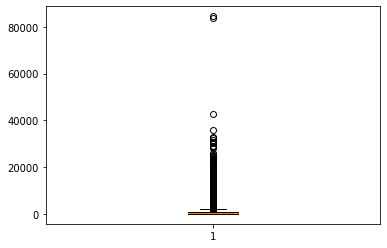

In [15]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
box_area=plt.boxplot(visits['session_duration_sec'])# строим диаграмму размаха
print([item.get_ydata() for item in box_area['whiskers']]) # определяем концы усов в диаграмме размаха
print(visits['session_duration_sec'].describe())

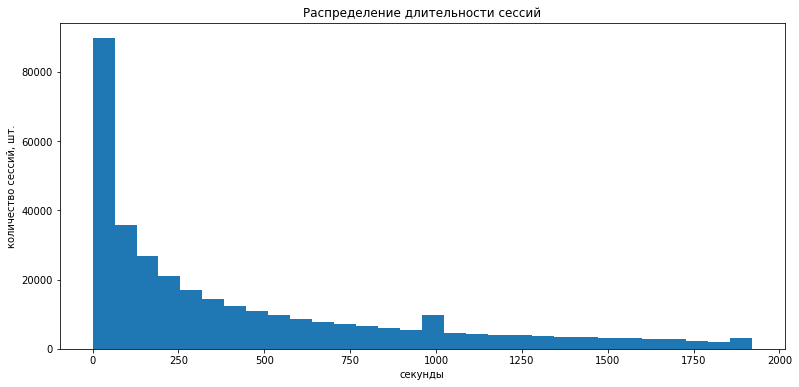

In [16]:
visits_dur = visits[visits['session_duration_sec']<= 1920]# отбрасываем выбросы
visits_dur['session_duration_sec'].plot.hist(bins=30, figsize = (13, 6), title = 'Распределение длительности сессий');
plt.xlabel("секунды")
plt.ylabel("количество сессий, шт.");

Рассчитаем длительность одной сессии. Для этого рассчитаем длительность всех сессий в секундах и выведем для получившегося столбца  описательные характеристики. Построим гистограмму распределения.
Средняя продолжительность сессии составила чуть менее 11 минут, а медианная - 5 минут: Большинство посетителей принимают решения о развлечениях достаточно быстро. 
Гистограмма похожа на логнормальное распределение.

#### Как часто люди возвращаются?

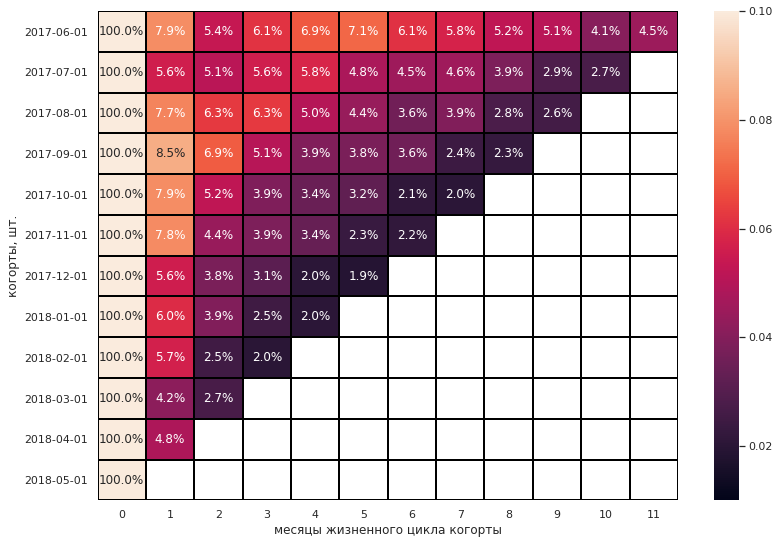

In [17]:
import seaborn as sns
visits['activity_date'] = pd.to_datetime(visits['start_ts'])
first_activity_date = visits.groupby(['uid'])['activity_date'].min()
first_activity_date.name = 'first_activity_date'
visits_1 = visits.join(first_activity_date, on='uid')
visits_1['activity_month'] = visits_1['activity_date'].astype('datetime64[M]')
visits_1['first_activity_month'] = visits_1['first_activity_date'].astype('datetime64[M]')
visits_1['cohort_lifetime'] = visits_1['activity_month'] - visits_1['first_activity_month']
visits_1['cohort_lifetime'] = visits_1['cohort_lifetime'] / np.timedelta64(1,'M')
visits_1['cohort_lifetime'] = visits_1['cohort_lifetime'].round().astype('int')
cohorts = visits_1.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
cohorts['first_activity_month'] = cohorts['first_activity_month'].dt.date
retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
sns.set(style='whitegrid')
plt.figure(figsize=(13, 9))
sns.heatmap(retention_pivot, annot=True, fmt='0.1%', linewidths=1, linecolor='black', vmin = 0.01, vmax = 0.1);
plt.xlabel("месяцы жизненного цикла когорты")
plt.ylabel("когорты, шт.");

Рассчитаем таблицу retention rate (возвратов пользователей) для каждой месячной когорты.
Для Яндекс.Афиши уровень возвратов достаточно низкий. Видимо, заядлых театралов, киноманов и поклонников звезд эстрады в России не много. В основном люди посещают развлекательные мероприятия от случая к случаю.
Наибольшей "стабильностью" отличается когорта июня 2017 г., которая к маю 2018 г. сохранила 4,5% своих пользователей, больше всего своих пользователей потеряла когорта декабря 2017 г., в которой к маю осталось менее 2%.

#### Анализ устройств и источников

device
desktop    262567
touch       96833
Name: uid, dtype: int64


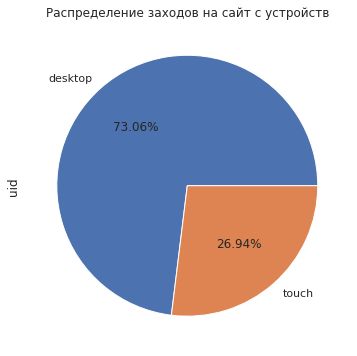

In [18]:
visits_device = visits.groupby('device')['uid'].count()
print(visits_device)
visits_device.plot.pie(figsize = (13, 6), autopct='%1.2f%%', title = 'Распределение заходов на сайт с устройств');

Рассмотрим с каких устройств пользователи заходят на сайт Яндекс.Афиша. Подавляющее большинство заходят с компьютеров. С мобильных устройств заходят гораздо меньше. Видимо, находу читать рекламу не очень удобно.

device
desktop    703.946977
touch      479.619407
Name: session_duration_sec, dtype: float64


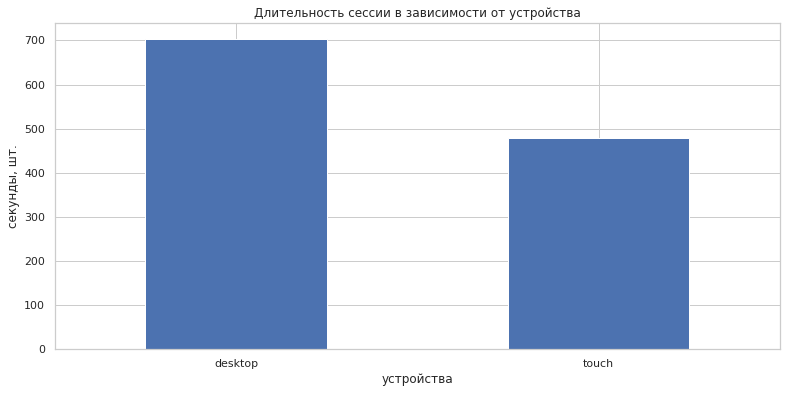

In [19]:
device_dur = visits.groupby('device')['session_duration_sec'].mean()
print(device_dur)
device_dur.plot.bar(figsize = (13, 6), title = 'Длительность сессии в зависимости от устройства');
plt.xticks(rotation=0)
plt.xlabel("устройства")
plt.ylabel("секунды, шт.");

Рассмотрим длительность сессий в зависимости от устройства. Длительность сессий с компьютеров почти в 1,5 больше аналогичного показателя с мобильных устройств.

source_id
1      34121
2      47626
3      85610
4     101794
5      66905
6          6
7         36
9      13277
10     10025
Name: uid, dtype: int64


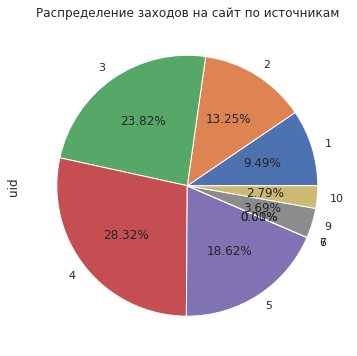

In [20]:
visits_source_id = visits.groupby('source_id')['uid'].count()
print(visits_source_id)
visits_source_id.plot.pie(figsize = (13, 6), autopct='%1.2f%%',  title = 'Распределение заходов на сайт по источникам');


Рассмотрим из каких рекламных источников пользователи заходят на сайт Яндекс.Афиша. Первые места по посещению занимают источники 4, 3 и 5. Самые неэффективные, с точки зрения привлечения пользователей, источники 6 и 7.

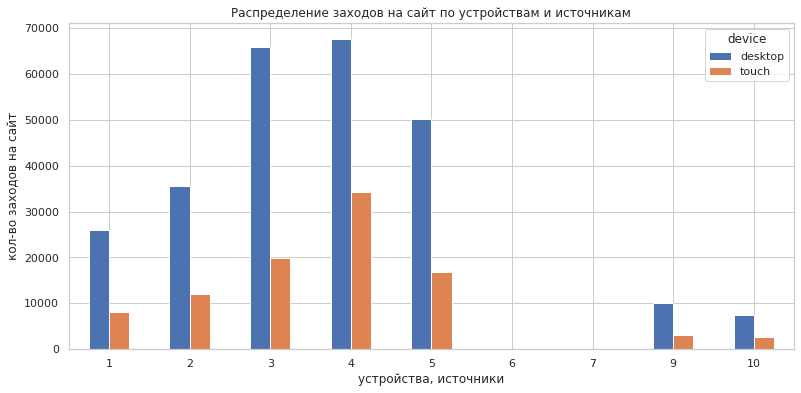

In [21]:
sour_dev=visits.pivot_table(index='source_id',columns='device',values='uid',aggfunc='count')
sour_dev.plot.bar(figsize = (13, 6), title = 'Распределение заходов на сайт по устройствам и источникам');
plt.xticks(rotation=0)
plt.xlabel("устройства, источники")
plt.ylabel("кол-во заходов на сайт");

Рассмотрим количество заходов на сайт в зависимости от источника и от устройства. Для этого построим сводную таблицу.
Для каждого источника (кроме 4) соотношение заходов с мобильных устройств к заходам с компьютеров - 1 к 3, у источника 4 это соотношение равно 1 к 2.

#### 3.2. Продажи

#### Когда люди начинают покупать?

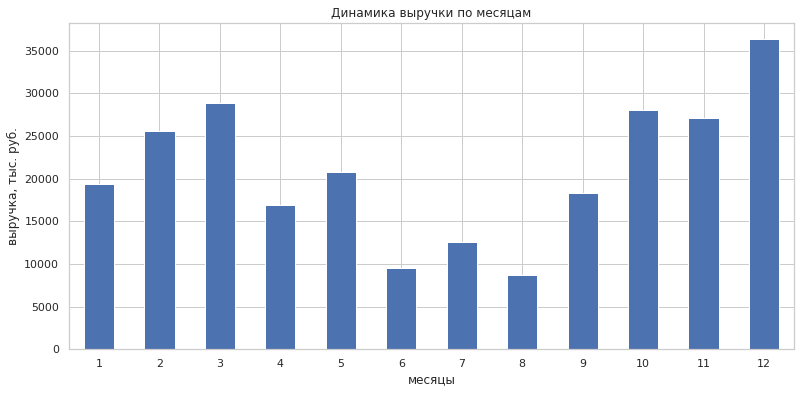

In [22]:
orders['buy_month'] = orders['buy_ts'].dt.month
buy_time = orders.groupby('buy_month')['revenue'].sum()
buy_time.plot.bar(figsize = (13, 6), title = 'Динамика выручки по месяцам')
plt.xticks(rotation=0)
plt.xlabel("месяцы")
plt.ylabel("выручка, тыс. руб.");

Рассмотрим зависимость выручки от времени. Минимальная выручка наблюдается в летние месяцы, максимальная в декабре, что связано с большим количеством выходных в новогодние праздники.

count    36523.000000
mean       249.164691
std        429.742785
min          0.000000
25%          4.000000
50%         16.000000
75%        252.000000
max       1439.000000
dtype: float64


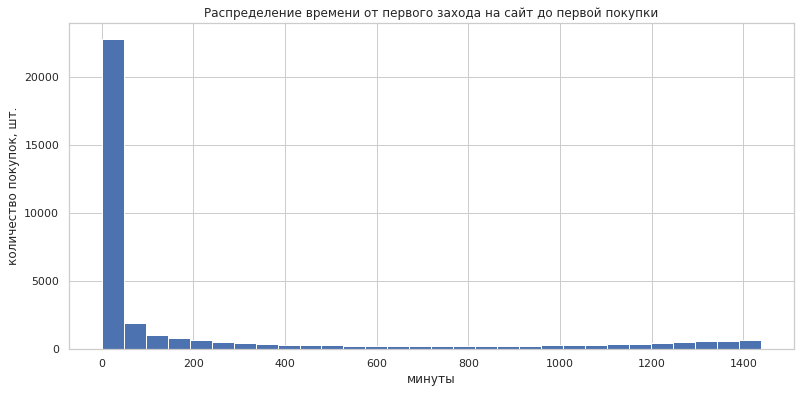

In [23]:
first_buy_date = orders.groupby(['uid'])['buy_ts'].min()
first_buy_date.name = 'first_buy_date' # определение даты первой покупки
orders_1 = orders.join(first_buy_date, on='uid', how = 'left')
orders_1 = orders_1.merge(visits_1, on='uid').reset_index() # объединение таблиц визитов и покупок
orders_2 = orders_1.loc[:, ['uid', 'first_buy_date', 'first_activity_date']].drop_duplicates()
time_before_buy = (orders_2['first_buy_date'] - orders_2['first_activity_date']) # расчет времени от первого визита до первой покупки
time_before_buy = (time_before_buy.dt.seconds/60).round()
print(time_before_buy.describe())
time_before_buy.plot.hist(bins=30, figsize = (13, 6), title = 'Распределение времени от первого захода на сайт до первой покупки');
plt.xlabel("минуты")
plt.ylabel("количество покупок, шт.");

Рассчитаем время, которое проходит от первого визита на сайт Яндекс.Афиша до первой покупки билета. Как видно из полученных показателей среднее время, прошедшее от первого визита до первой покупки составляет более 4 часов. Однако, медианное значение показателя составляет 16 минут. 
Можно заметить условное деление пользователей на 2 группы: первые принимают решение быстро (их подавляющее большинство) и вторые, которым надо подумать от нескольких часов до суток.

#### Сколько раз покупают за период?

Покупки по дням


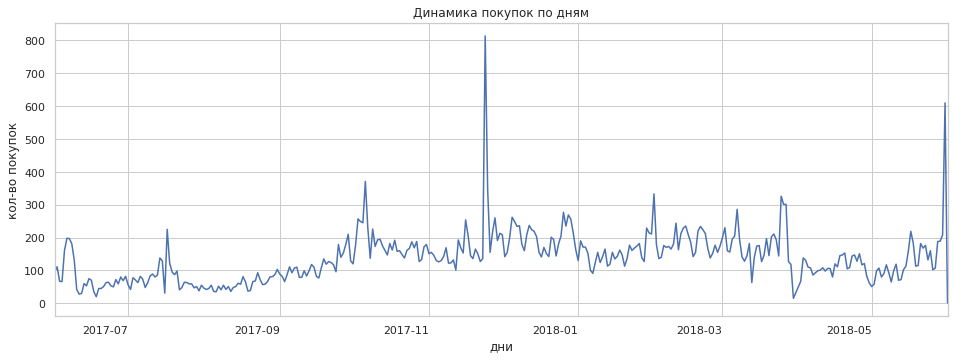

In [24]:
orders['buy_day'] = orders['buy_ts'].astype('datetime64[D]')
orders['buy_week'] = orders['buy_ts'].astype('datetime64[W]')
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')
print('Покупки по дням')
orders.groupby(['buy_day'])['uid'].count().plot.line(figsize = (16, 6), title = 'Динамика покупок по дням');
orders.groupby(['buy_day'])['uid'].count().describe()
plt.xticks(rotation=0)
plt.xlabel("дни")
plt.ylabel("кол-во покупок");

Покупки по неделям


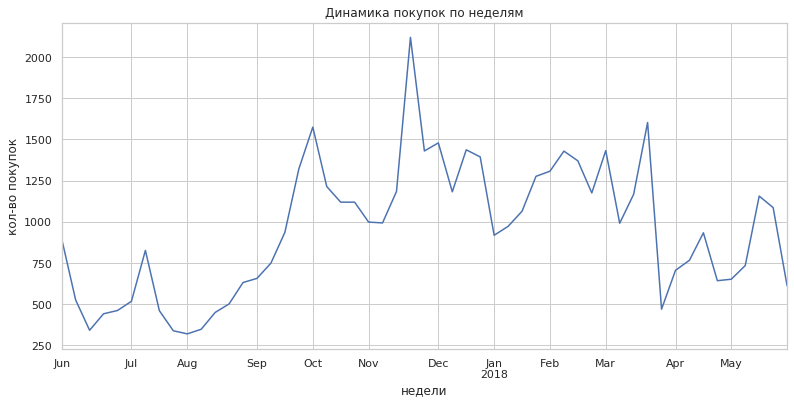

In [25]:
print('Покупки по неделям')
orders.groupby(['buy_week'])['uid'].count().plot.line(figsize = (13, 6), title = 'Динамика покупок по неделям');
orders.groupby(['buy_week'])['uid'].count().describe()
plt.xlabel("недели")
plt.ylabel("кол-во покупок");

Покупки по месяцам


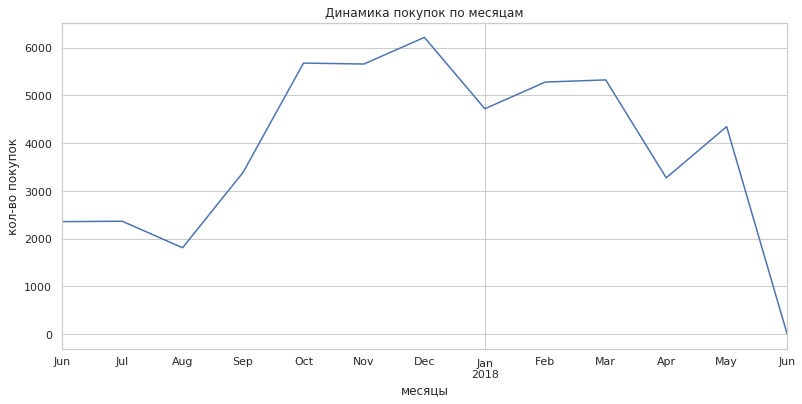

In [26]:
print('Покупки по месяцам')
orders.groupby(['buy_month'])['uid'].count().plot.line(figsize = (13, 6), title = 'Динамика покупок по месяцам');
orders.groupby(['buy_month'])['uid'].count().describe()
plt.xlabel("месяцы")
plt.ylabel("кол-во покупок");

Рассчитаем количество покупок по периодам (дням, неделям, месяцам) и характеристики распределений покупок по периодам.
Как видно, средние показатели не существенно отличаются от медианных.
В день в среднем пользователи осуществляют 139 покупок билетов, в неделю - 951 покупку, в месяц - 4346 (использована медиана, т.к. июнь 2018 г. представлен 1 покупкой, что не показательно).
Что касается, распределения покупок по году, то следует отметить, что максимальные значения количества покупок наблюдаются в конце 2017 г., что обусловлено тем, что люди берут мало отпусков в период с октября по март, новогодними праздниками, когда родители стараются сводить детей на новогодние елки и т.п.). Минимальные значения покупок наблюдаются в летние месяцы (периоды отпусков, люди уезжают в отпуска и на дачи: не до развлекательных мероприятий).

#### Какой средний чек?

Средний чек по дням


count    364.000000
mean       4.936188
std        2.021881
min        1.948000
25%        3.960635
50%        4.561548
75%        5.411037
max       29.133313
dtype: float64

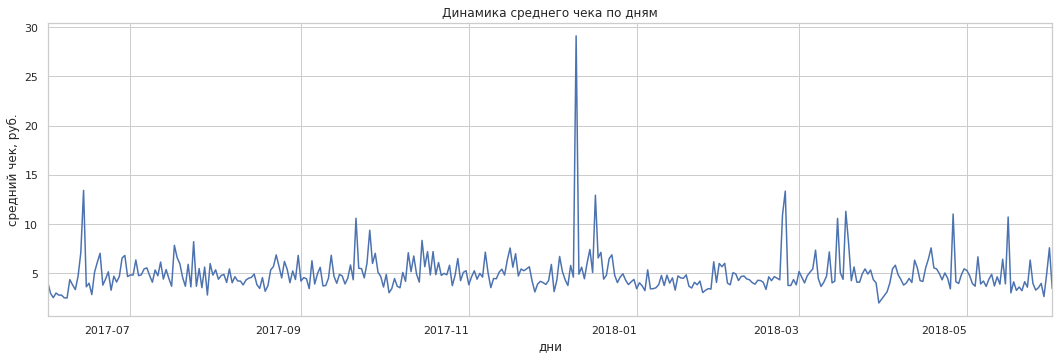

In [27]:
mean_check_day = orders.groupby(['buy_day'])['revenue'].sum()/orders.groupby(['buy_day'])['uid'].count()
print('Средний чек по дням')
mean_check_day.plot.line(figsize = (18, 6), title = 'Динамика среднего чека по дням');
plt.xticks(rotation=0)
plt.xlabel("дни")
plt.ylabel("средний чек, руб.");
mean_check_day.describe()

Средний чек по неделям


count    53.000000
mean      4.995856
std       0.967166
min       2.842254
25%       4.342249
50%       4.831448
75%       5.343722
max       7.557021
dtype: float64

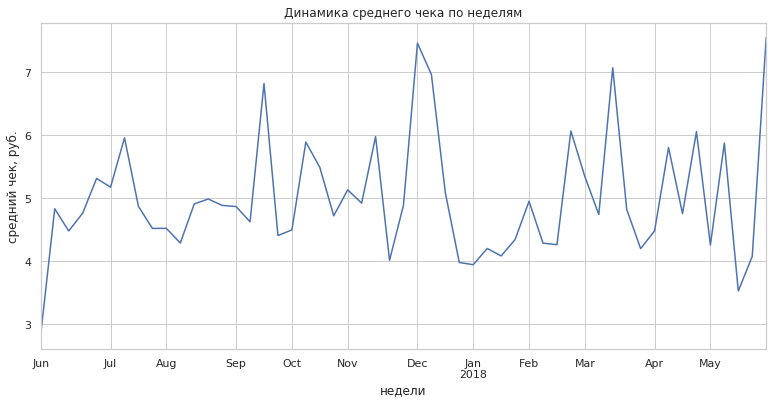

In [28]:
mean_check_week = orders.groupby(['buy_week'])['revenue'].sum()/orders.groupby(['buy_week'])['uid'].count()
print('Средний чек по неделям')
mean_check_week.plot.line(figsize = (13, 6), title = 'Динамика среднего чека по неделям');
plt.xlabel("недели")
plt.ylabel("средний чек, руб.");
mean_check_week.describe()

Средний чек по месяцам


count    13.000000
mean      4.838700
std       0.656336
min       3.420000
25%       4.771279
50%       4.847139
75%       5.306589
max       5.852139
dtype: float64

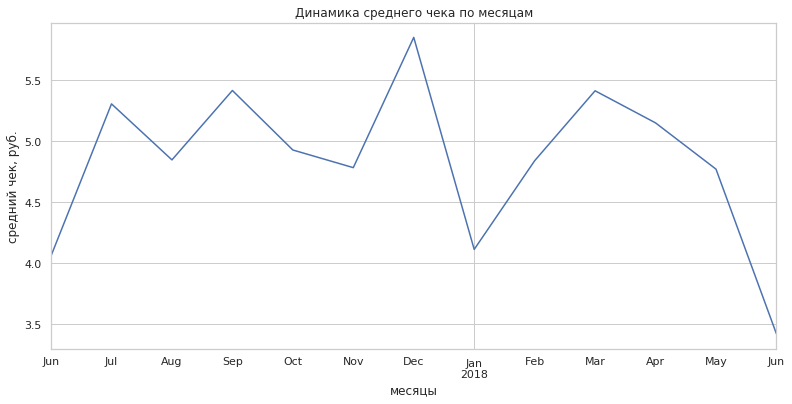

In [29]:
mean_check_month = orders.groupby(['buy_month'])['revenue'].sum()/orders.groupby(['buy_month'])['uid'].count()
print('Средний чек по месяцам')
mean_check_month.plot.line(figsize = (13, 6), title = 'Динамика среднего чека по месяцам');
plt.xlabel("месяцы")
plt.ylabel("средний чек, руб.");
mean_check_month.describe()

Рассчитаем сумму среднего чека по периодам (дням, неделям, месяцам) и характеристики распределений покупок по периодам.
Сумма среднего чека составляет около 5 т.р. на 1 пользователя. Средняя величина чека приблизительно равна медианной.
Максимальная сумма среднего чека наблюдается в декабре 2017 г., что обусловлено предверием новогодних праздников, когда проходят много премьер и концертов. Минимальные значения средних чеков наблюдаются в январе 2018 г. (окончание новогодних праздников), июне 2017 и июне 2018 (начало периода отпусков).

#### Сколько денег приносят? (LTV)

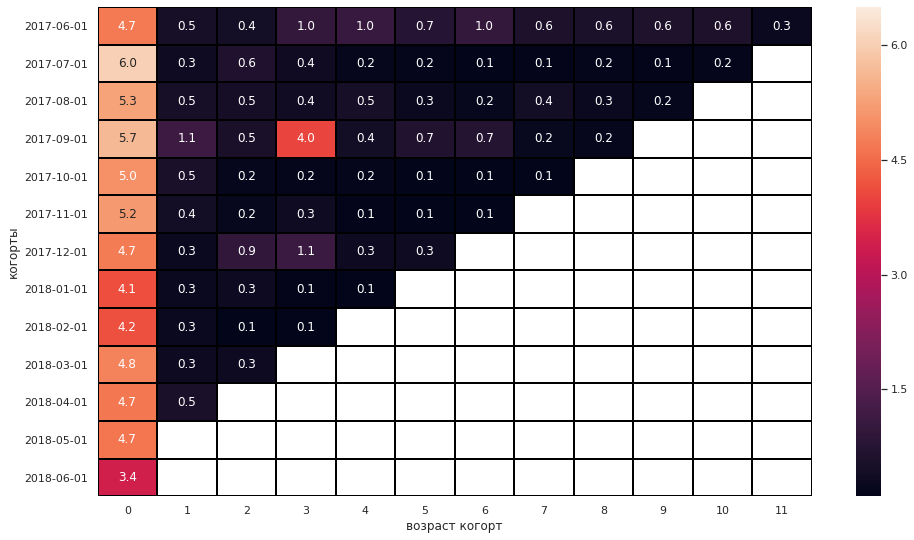

In [30]:
uid_orders = orders['uid'].unique() # создаем список уникальных uid
buyers_visits = visits.query('uid in @uid_orders and session_duration_sec > 0') # выбираем из visits сессии с заказами
visits_orders = orders.join(buyers_visits.groupby('uid').agg({'start_ts': 'min', 'source_id': 'first'}), on='uid', how='inner').drop('start_ts', axis=1) # соединяем сессии с заказами и данные о заказах
visits_orders['buy_date'] = pd.to_datetime(visits_orders['buy_ts'].dt.date) # выделяем дату покупки для соединения
visits_orders['buy_month'] = visits_orders['buy_date'].astype('datetime64[M]')# выделение месяца покупки
first_orders = visits_orders.groupby('uid').agg({'buy_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_buy_month']
cohort_sizes = first_orders.groupby('first_buy_month').agg({'uid': 'nunique'}).reset_index()# разбиение покупателей по когортам
cohort_sizes.columns = ['first_buy_month', 'n_buyers']
visits_orders_2 = pd.merge(visits_orders,first_orders, on='uid')
cohorts = visits_orders_2.groupby(['first_buy_month','buy_month']).agg({'revenue': 'sum'}).reset_index()# разбиение выручки по когортам
report = pd.merge(cohort_sizes, cohorts, on='first_buy_month')
report['cohort_lifetime'] = (report['buy_month'] - report['first_buy_month']) / np.timedelta64(1, 'M')
report['cohort_lifetime'] = report['cohort_lifetime'].round().astype('int')
report['first_buy_month'] = report['first_buy_month'].dt.date
report['ltv'] = report['revenue'] / report['n_buyers']# расчет ltv
ltv_pivot = report.pivot_table(index='first_buy_month', columns='cohort_lifetime', values='ltv', aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(16, 9))
sns.heatmap(ltv_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='black', vmin = 0.1, vmax = 6.5);
plt.xlabel("возраст когорт")
plt.ylabel("когорты");

Рассчитаем стоимость покупателей по когортам (ltv). Маржинальность, т.к. она не задана, пусть будет 100%. Наибольшая стоимость у покупателей сентября 2017 г. и июня 2017 г., наименьшая - у покупателей февраля и мая 2018. Июнь 2018 не показателен, там 1 покупатель.

#### 3.3. Маркетинг

#### Сколько денег потратили? Всего / на каждый источник / по времени

In [31]:
costs['costs'].sum()

329131.62

Рассчитаем общие затраты на рекламу. Они составили 329 131,62 тыс. руб.

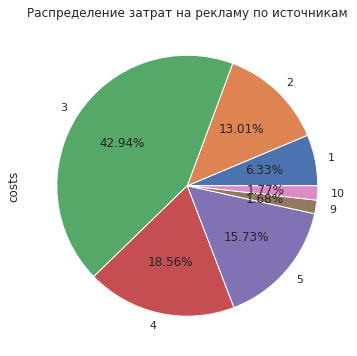

In [32]:
source_cost = costs.groupby('source_id')['costs'].sum()
source_cost.plot.pie(figsize = (13, 6), autopct='%1.2f%%', title = 'Распределение затрат на рекламу по источникам');

Рассчитаем затраты на рекламу по источникам. Наибольшие затраты были осуществлены по источникам 3 (42.9%), 4 (18,6%), 5 (15,7%).

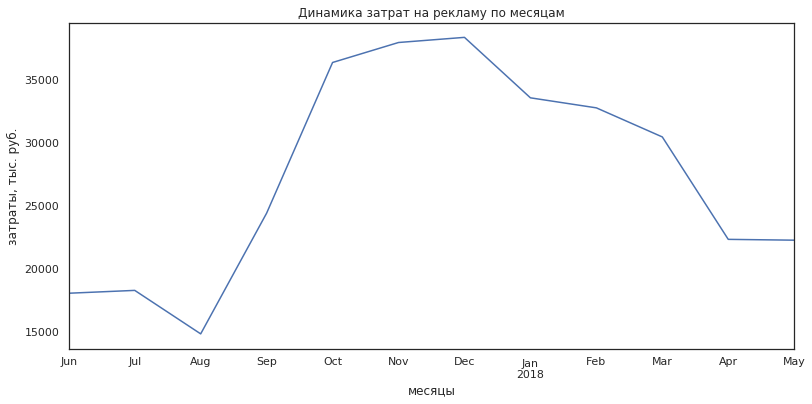

In [33]:
costs['cost_month'] = costs['dt'].astype('datetime64[M]')
cost_time = costs.groupby('cost_month')['costs'].sum()
cost_time.plot.line(figsize = (13, 6), title = 'Динамика затрат на рекламу по месяцам');
plt.xlabel("месяцы")
plt.ylabel("затраты, тыс. руб.");

Рассчитаем затраты на рекламу по месяцам. Наибольшие затраты осуществлялись в ноябре и декабре 2017 г. (видимо в предверии новогодних праздников), наименьшие - июне-июле 2017 г. (период отпусков).

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


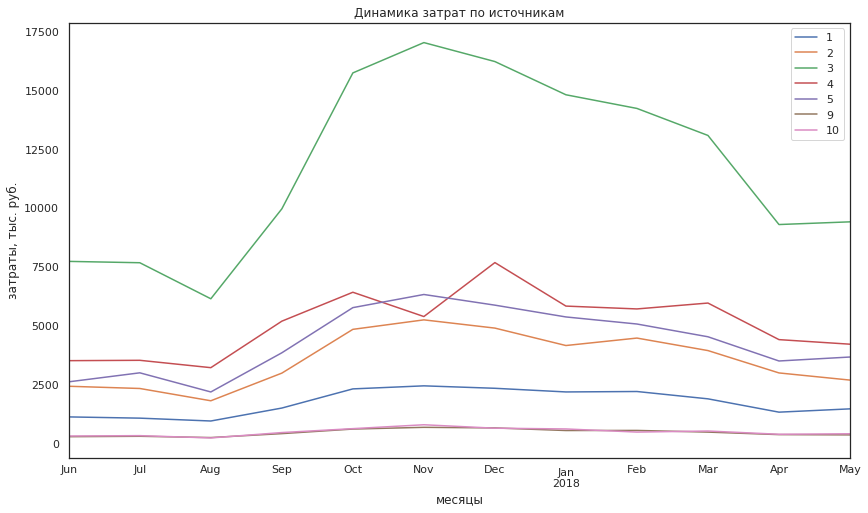

In [34]:
s = costs['source_id'].unique()
for source in s:
    cost_time_s = costs.groupby([costs.source_id == source, 'cost_month']).agg({'costs': 'sum'}).drop(False).reset_index()
    ax=plt.subplot()
    cost_time_s.plot.line(figsize = (14, 8), x = 'cost_month', ax=ax, title = 'Динамика затрат по источникам')
    ax.legend(s)
    plt.xlabel("месяцы")
    plt.ylabel("затраты, тыс. руб.");
plt.show()

Построим графики затрат по каждому источнику. Следует отметить, что графики для всех источников, кроме 4, похожи: минимум в августе, максимум в ноябре и снижение до мая.
На графике для источника 4 ярко выраженный максимум в декабре, далее снижение с небольшим подъемом в марте.
Относительно объемов затрат видно, что с большим отрывом лидирует источник 3, за ним следуют источники 4, 5 и 2, затем через промежуток источник 1 и где-то около 0 источники 9 и 10.

#### Сколько стоило привлечение одного покупателя из каждого источника?

In [35]:
visits_orders_grouped = visits_orders_2.groupby(['buy_month', 'source_id', 'first_buy_month']).agg({'uid': 'count','revenue': 'sum'}).reset_index()# суммируем прибыль и считаем покупателей по дате и источнику
buy_source_month = visits_orders_grouped.groupby(['buy_month', 'source_id']).agg({'uid': 'sum','revenue': 'sum'}).reset_index()
visits_orders_grouped_2 = visits_orders_grouped.query('buy_month == first_buy_month')# составляем таблицу только с новыми покупателями
first_buy_source_month = visits_orders_grouped_2.groupby(['first_buy_month', 'source_id']).agg({'uid': 'sum'}).reset_index()# группируем новых покупателей по месяцам и источникам
costs_source_month = costs.groupby(['cost_month', 'source_id']).agg({'costs': 'sum'}).reset_index()# группируем расходы по месяцам и источникам
first_buy_costs = first_buy_source_month.merge(costs_source_month, left_on =['first_buy_month', 'source_id'], right_on=['cost_month', 'source_id'], how='inner')# соединяем группировки расходов и новых покупателей
first_buy_costs = first_buy_costs.rename({'uid': 'uid_2'}, axis = 1)
cost_buy = first_buy_costs.merge(buy_source_month, left_on =['cost_month', 'source_id'], right_on=['buy_month', 'source_id'])# соединяем данные о заказах и затратах на маркетинг
cost_buy['ltv'] = cost_buy['revenue'] / cost_buy['uid']
cost_buy['cac'] = cost_buy['costs'] / cost_buy['uid_2']
cost_buy.sample(5)

,first_buy_month,source_id,uid_2,cost_month,costs,buy_month,uid,revenue,ltv,cac
75,2018-04-01,9,52,2018-04-01,373.49,2018-04-01,92,474.69,5.159674,7.182500
52,2018-01-01,4,1073,2018-01-01,5832.79,2018-01-01,1233,4292.20,3.481103,5.435965
14,2017-08-01,1,174,2017-08-01,951.81,2017-08-01,251,1310.37,5.220598,5.470172
23,2017-09-01,3,694,2017-09-01,9963.55,2017-09-01,719,3361.96,4.675883,14.356700
70,2018-04-01,1,288,2018-04-01,1327.49,2018-04-01,494,3650.27,7.389211,4.609340


Рассчитаем затраты и количество заказов для каждого источника в каждом месяце рассматриваемого периода. Проверяем.

In [36]:
print('Средний ltv на 1 покупателя:', cost_buy['revenue'].sum()/cost_buy['uid'].sum())
print('Средний cac на 1 покупателя:',cost_buy['costs'].sum()/cost_buy['uid_2'].sum())

Средний ltv на 1 покупателя: 5.00956607060614
Средний cac на 1 покупателя: 8.003395097753135


Рассчитаем среднюю выручку от 1 покупателя и средние расходы на привлечение 1 покупателя. Показатели составили 5,0 и 8,0, соответственно. 

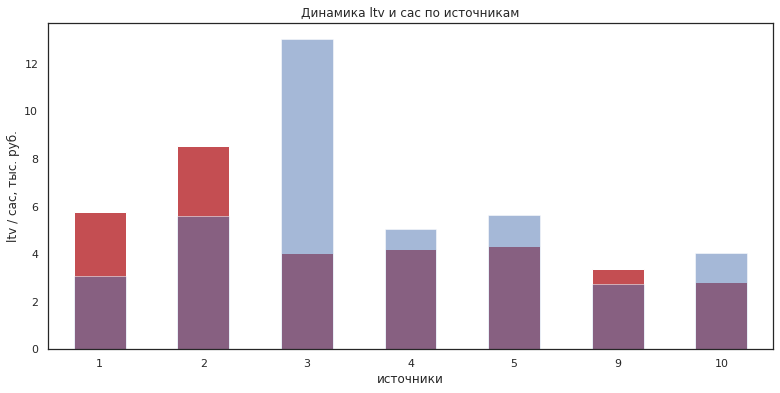

In [37]:
orders_costs_source = cost_buy.groupby('source_id').agg({'revenue': 'sum', 'costs': 'sum', 'uid': 'sum'})
orders_costs_source['ltv'] = orders_costs_source['revenue']/orders_costs_source['uid']
orders_costs_source['cac'] = orders_costs_source['costs']/orders_costs_source['uid']
orders_costs_source['roi'] = orders_costs_source['ltv']/orders_costs_source['cac']
orders_costs_source['ltv'].plot.bar(x = 'source_id', figsize = (13, 6), color = 'r', title = 'Динамика ltv и cac по источникам')
orders_costs_source['cac'].plot.bar(x = 'source_id', figsize = (13, 6), alpha = 0.5);
plt.xticks(rotation=0)
plt.xlabel("источники")
plt.ylabel("ltv / cac, тыс. руб.");

Рассчитаем ltv и cac на 1 покупателя по источникам. Наибольшие значения стоимости покупателя (ltv) у источников 2 и 1, наименьшие - у 9 и 10. Наибольшие значения стоимостей привлечения 1 покупателя у источников 3 и 2, наименьшие - у источников 1 и 9.
Исходя из графика видно, что источники 1, 2 и 9 окупают себя, остальные источники - нет.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


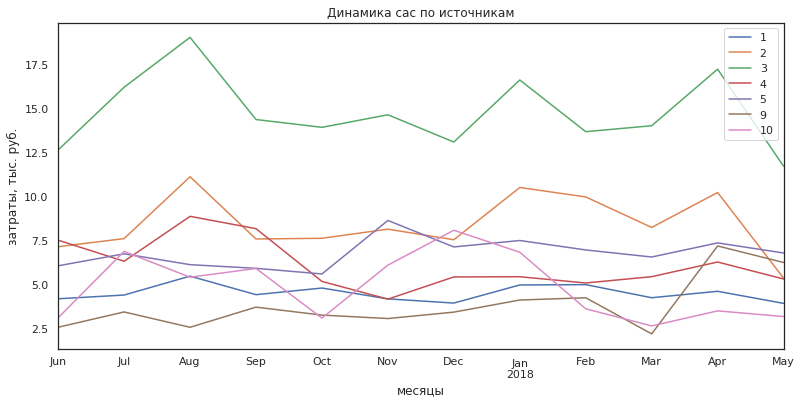

In [38]:
os = cost_buy['source_id'].unique()
for source in os:
    cac_m = cost_buy[cost_buy.source_id == source].groupby('cost_month').apply(lambda x :np.average(x['cac'], weights=x['uid'])).reset_index()
    ax=plt.subplot()
    cac_m.plot.line(figsize = (13, 6), x = 'cost_month', ax=ax, title = 'Динамика cac по источникам');
    ax.legend(os)
    plt.xlabel("месяцы")
    plt.ylabel("затраты, тыс. руб.")
plt.show();

Построим графики привлечения 1 покупателя по источникам в динамике. У источников 2 и 3 пики финансирования наблюдались в августе 2017 г., январе и апреле 2018. У остальных источников было по одному выраженному пику финансирования. У источников 1 и 4 - август 2017, у источника 5 - ноябрь, у источника 9 - апрель 2018, у источника 10 - декабрь 2017. 
Самая высокая стоимость привлечения 1 покупателя на протяжении года была у источника 3.
Источники 2, 4 и 5 делят 2-4 места по стоимости привлечения 1 покупателя.
Источник 10 на протяжении года был самым нестабильным: то одним из самых экономных, то одним из самых дорогих.
Источники 1 и 9, напротив, отличались стабильностью на протяжении года: стоимость привлечения 1 покупателя у них была  низкой.

In [39]:
cost_buy_source_3 = cost_buy.query('source_id == 3')
sour_3 = cost_buy_source_3.groupby(['cost_month']).agg({'costs': 'sum', 'uid_2': 'sum'}).reset_index()
sour_3['cac'] = sour_3['costs'] / sour_3['uid_2']
sour_3

,cost_month,costs,uid_2,cac
0,2017-06-01,7731.65,612,12.633415
1,2017-07-01,7674.37,474,16.190654
2,2017-08-01,6143.54,323,19.020248
3,2017-09-01,9963.55,694,14.356700
4,2017-10-01,15737.24,1131,13.914447
5,2017-11-01,17025.34,1164,14.626581
6,2017-12-01,16219.52,1240,13.080258
7,2018-01-01,14808.78,892,16.601771
8,2018-02-01,14228.56,1041,13.668165
9,2018-03-01,13080.85,934,14.005193


#### На сколько окупились расходы? (ROI)

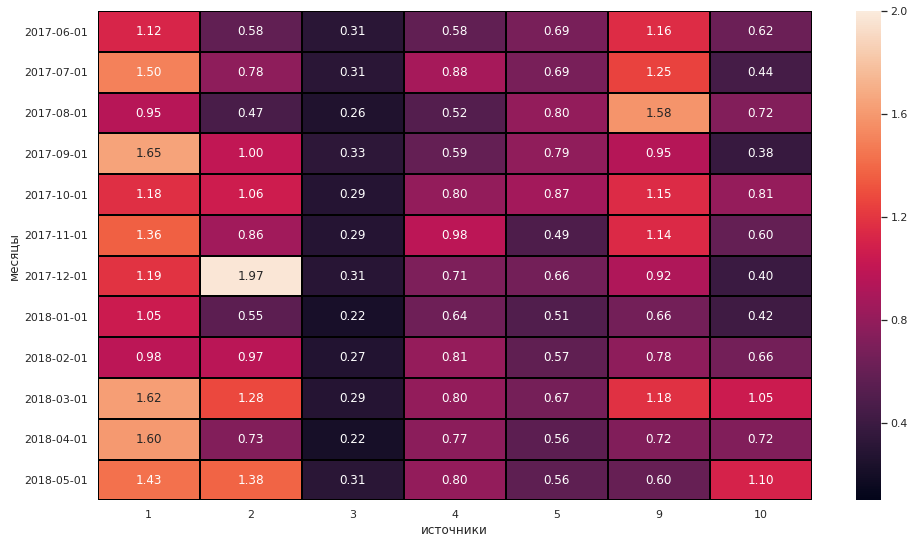

In [40]:
orders_costs_ltv = cost_buy.groupby(['source_id', 'cost_month']).apply(lambda x :np.average(x['ltv'], weights=x['uid'])).reset_index()
orders_costs_ltv = orders_costs_ltv.rename({0: 'ltv'}, axis = 1)
orders_costs_cac = cost_buy.groupby(['source_id', 'cost_month']).apply(lambda x :np.average(x['cac'], weights=x['uid'])).reset_index()
orders_costs_cac = orders_costs_cac.rename({0: 'cac'}, axis = 1)
orders_costs_roi = orders_costs_ltv.merge(orders_costs_cac, on =['source_id', 'cost_month'])
orders_costs_roi['roi'] = orders_costs_roi['ltv']/orders_costs_roi['cac']
orders_costs_roi['cost_month'] = orders_costs_roi['cost_month'].dt.date
roi = orders_costs_roi.pivot_table(index='cost_month', columns='source_id', values='roi', aggfunc='mean')
sns.set(style='white')
plt.figure(figsize=(16, 9))
sns.heatmap(roi, annot=True, fmt='.2f', linewidths=1, linecolor='black', vmin = 0.1, vmax = 2);
plt.xlabel("источники")
plt.ylabel("месяцы");

Рассчитаем отношение выручки от 1 покупателя к расходам на привлечение 1 покупателя (roi) по источникам рекламы. Как и в ранее полученной таблице, видно, что окупают себя только источники 1, 2 и 9. Причем, если источники 1 и 9 стабильно прибыльны, источник 2 убыточен с июня по август. Из убыточных источников обращает на себя внимание источник 4, которому немного не хватает для выхода на окупаемость.

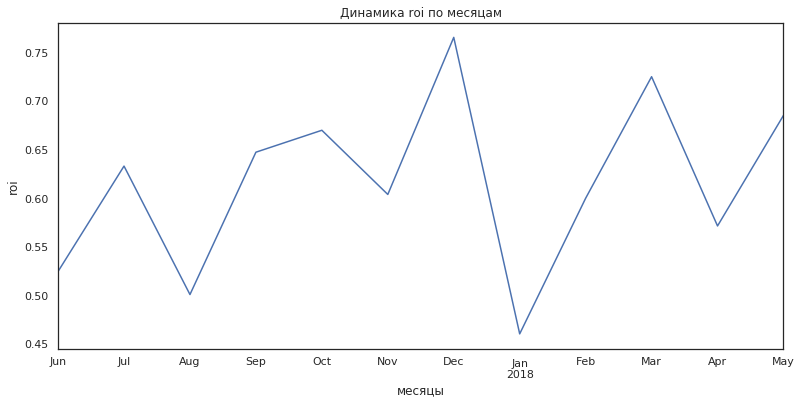

In [41]:
orders_costs_time = cost_buy.groupby('cost_month').agg({'revenue': 'sum', 'costs': 'sum', 'uid': 'sum', 'uid_2': 'sum'})
orders_costs_time['ltv'] = orders_costs_time['revenue']/orders_costs_time['uid']
orders_costs_time['cac'] = orders_costs_time['costs']/orders_costs_time['uid_2']
orders_costs_time['roi'] = orders_costs_time['ltv']/orders_costs_time['cac']
orders_costs_time['roi'].plot.line(x = 'source_id', figsize = (13, 6), title = 'Динамика roi по месяцам')
plt.xticks(rotation=0)
plt.xlabel("месяцы")
plt.ylabel("roi");

Рассчитаем показатель roi в динамике. Как видно, на протяжении года он был убыточен. Наиболее "успешные" месяцы - декабрь 2017, март и май 2018.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


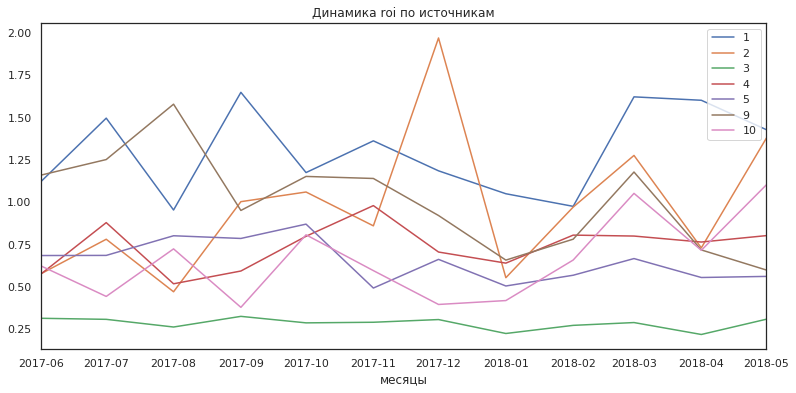

In [42]:
cs = costs['source_id'].unique()
for source in cs:
    roi_time = orders_costs_roi.groupby([orders_costs_roi.source_id == source, 'cost_month']).agg({'roi': 'sum'}).drop(False).reset_index()
    ax=plt.subplot()
    roi_time.plot.line(figsize = (13, 6), x = 'cost_month', ax=ax, title = 'Динамика roi по источникам');
    ax.legend(cs)
    plt.xlabel("месяцы");
plt.show()

Рассмотрим roi  в динамике по источникам. Подтверждаются выводы, сделанные ранее: прибыльные источники 1, 2 и 9 (большинство значений на протяжении года выше 1). Остальные убыточны, но у источников 4 и 10 есть потенциал выйти в прибыль, а у источника 9, наоборот, - в убытки.
Roi по источникам 1, 2, 4, 10 демонстрируют тенденцию к росту.
Roi источника 9, напротив, на протяжении года снижался.
Roi по источникам 3 и 5 демонстрируют стабильность.
Возможно, все указанные тенденции - сезонные, однако, наверняка утверждать это нельзя, для окончательного вывода нужно рассмотреть развитие ситуации за несколько лет.

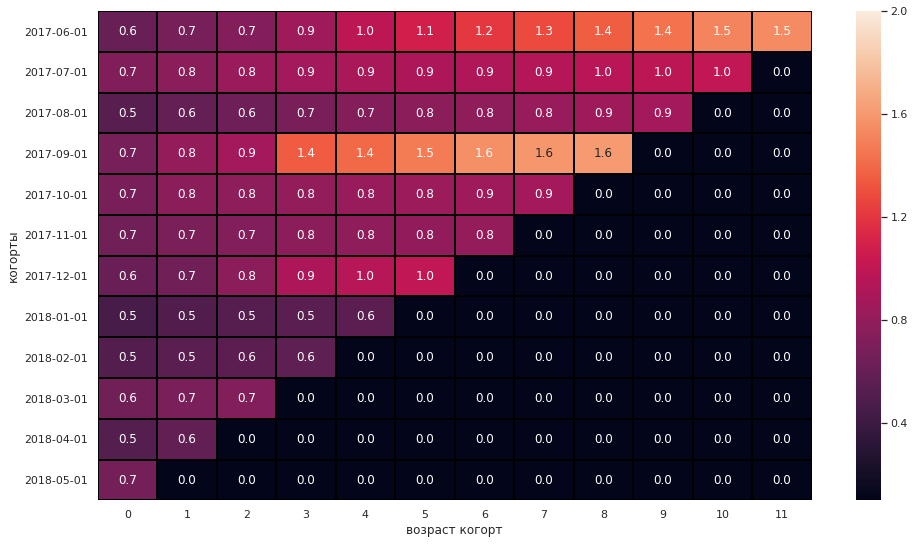

In [43]:
cum_ltv = ltv_pivot.cumsum(axis=1).fillna(0).reset_index()
costs_month = cost_buy.groupby(['cost_month']).agg({'costs':'sum', 'uid_2': 'sum'}).reset_index()
costs_month['cac'] = costs_month['costs'] / costs_month['uid_2']
cum_ltv['first_buy_month'] = cum_ltv['first_buy_month'].astype('datetime64[M]')
cum_ltv_cac = cum_ltv.merge(costs_month, left_on = ['first_buy_month'], right_on = ['cost_month'])
cum_ltv_cac
for i in range(12):
    cum_ltv_cac[i] =  cum_ltv_cac[i]/cum_ltv_cac['cac']
cum_ltv_cac_fin = cum_ltv_cac.loc[:,['first_buy_month',0,1,2,3,4,5,6,7,8,9,10,11]]
cum_ltv_cac_fin['first_buy_month']=cum_ltv_cac_fin['first_buy_month'].dt.date
cum_ltv_cac_fin.set_index('first_buy_month', inplace = True) 
sns.set(style='white')
plt.figure(figsize=(16, 9))
sns.heatmap(cum_ltv_cac_fin, annot=True, fmt='.1f', linewidths=1, linecolor='black', vmin = 0.1, vmax = 2);
plt.xlabel("возраст когорт")
plt.ylabel("когорты");

Построим таблицу roi по когортам. Как видно из таблицы, себя окупили когорты июня, июля, сентября и декабря. Остальные когорты принесли убытки. 

In [44]:
orders_costs_ltv = cost_buy['revenue'].sum() / cost_buy['uid'].sum()
orders_costs_cac = cost_buy['costs'].sum() / cost_buy['uid_2'].sum()
orders_costs_ltv / orders_costs_cac

0.62593012208188

Рассчитаем roi по всем источникам за год. Он составил 0,63, что говорит об убыточности вложений в рекламу. 

### 4. Выводы

Исходя из проведенного исследования можно сделать следующие выводы:
1. В среднем в день на Яндекс.Афишу заходят 907 пользователей.
2. Каждый из них в среднем заходит на сайт 1,1 раз в день и проводит в среднем на сайте около 11 минут. Большинство пользователей укладываются в 5 минут.
3. Показатели возврата пользователей (retention rate) достаточно низкие и не превышают 9% от начального уровня.
4. Большинство пользователей заходят на сайт со стационарных устройств (компьютеры, ноутбуки и т.п.).
5. Среднее время между первым заходом на сайт и покупкой билетов составляет 17 дней, однако медианное время - 16 минут.
6. В средне в день продаеются 139 билетов. Наиболее удачный месяц для продаж - декабрь (видимо, связано с новогодними праздниками).
7. Средняя цена покупки - около 5 тыс. руб. Максимальная цена покупки наблюдается также в декабре. В начале лета объем потраченых денег на билеты снижается.
8. Средняя стоимость одного покупателя за рассматриваемый период составляет чуть более 5 тыс. руб. Наиболее выгодные когорты - сентябрь и июнь 2017 г.
9. Средняя стоимость привлечения 1 покупателя составляет 6,6 тыс. руб., т.е. рекламная кампания убыточна.
10. Рекламные источники 1, 2 и 9 являются прибыльными, остальные убыточные.
Советы маркетинговому отделу:
1. Отказаться от финансирования рекламных источников 3, 5, 10. На рекламный источник 3 за рассматриваемый период была выделена самая большая сумма, эффект - крупные убытки.
2. Увеличить финансирование источников 1, 2 и 9. 
3. Провести исследовательскую работу по источникам 4 и 10: они имеют тенденцию к росту. Нужно стимулировать покупки по данным источникам, чтобы они стали прибыльными.
4. По источникам 3 и 5 снизить финансирование, до уровня окупаемости, либо прекратить финансирование, если невозможно вывести указанные источники в прибыль.